<a href="https://colab.research.google.com/github/Time-11-emiT/Contrastive_Learning/blob/main/ContrastiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning with Point Clouds

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import torch
version =f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try:
  import torch_geometric
except:
  !echo $version
  !pip install torch-scatter torch_sparse torch-cluster torch-spline-conv torch-geometric -f $version
  import torch_geometric

Note: The above 2 cells must be executed again after restarting the runtime everytime.

# Dataset
Using the ShapeNet Dataset


In [ ]:
from torch_geometric.datasets import ShapeNet
dataset=ShapeNet(root=".",categories=["Pistol","Motorbike","Car","Skateboard"]).shuffle()[:5000]
print("Number of Samples: ",len(dataset))
print("Sample: ",dataset[0])
#Pos---->Normalized positions as 3D coordinates
#X----->Normal Vectors
#Y------->Class Labels

Number of Samples:  1251
Sample:  Data(x=[2877, 3], y=[2877], pos=[2877, 3], category=[1])


In [ ]:
dataset[0].pos

tensor([[ 0.0336,  0.0524,  0.2003],
        [ 0.0680,  0.0461, -0.1376],
        [ 0.1128,  0.0237,  0.1608],
        ...,
        [-0.1273,  0.1312,  0.0854],
        [-0.1066, -0.0488, -0.0279],
        [-0.2558, -0.0235,  0.1429]])

Using plotly to inspect the data

In [ ]:
!pip install plotly --quiet
import plotly.express as px

def plot_3d_shape(shape):
  print("Number of data points: ",shape.x.shape[0])
  x=shape.pos[:,0]
  y=shape.pos[:,1]
  z=shape.pos[:,2]
  fig=px.scatter_3d(x=x,y=y,z=z,opacity=0.3)
  fig.show()


#picking a sample
sample_idx=42
plot_3d_shape(dataset[sample_idx])

Number of data points:  2584


In [ ]:
#Checking the distribution of classes
cat_dict={key:0 for key in dataset.categories}
for datapoint in dataset: cat_dict[dataset.categories[datapoint.category.int()]]+=1
cat_dict

{'Pistol': 239, 'Motorbike': 151, 'Car': 740, 'Skateboard': 121}

Data Preparation and Augmentation

In [ ]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

data_loader=DataLoader(dataset,batch_size=32,shuffle=True)

augmentation=T.Compose([T.RandomJitter(0.03),T.RandomFlip(1),T.RandomShear(0.2)])

Looking at some samples

In [ ]:
sample=next(iter(data_loader))
plot_3d_shape(sample[0])

Number of data points:  2783


In [ ]:
#Augmented data points
transformed=augmentation(sample)
plot_3d_shape(transformed[0])

Number of data points:  2783


# Model
Using the DynamicEdgeConv implementation in PyTorch geometric.



Different choices for Point Cloud Feature-Learning layers---->PointNet,PointNet++,EdgeConv, PointTransformer

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        # Encoder head
        self.lin1 = Linear(128 + 64, 128)
        # Projection head (See explanation in SimCLRv2)
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            # Extract properties
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            # Get representations for first augmented view
            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            # Get representations for second augmented view
            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))

            # Global representation
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

# Training

Using NT-Xent loss function preimplemented in PyTorch

In [ ]:
!pip install pytorch-metric-learning -q
from pytorch_metric_learning.losses import NTXentLoss
loss_func=NTXentLoss(temperature=0.10)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=Model().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.5)


#Use a larger batch size
data_loader=DataLoader(dataset,batch_size=32,shuffle=True)



*   No test dataset, as the evaulation can be done "downstream"
*   The compact representations go into the loss function
*   During test time no augmentations are applied and we can use the output representations





In [ ]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        # Prepare for loss
        embeddings = torch.cat((compact_h_1, compact_h_2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 4):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


Epoch 001, Loss: 2.5068


100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


Epoch 002, Loss: 2.3598


100%|██████████| 40/40 [01:42<00:00,  2.56s/it]

Epoch 003, Loss: 1.9335


# Evaluation of the Embeddings

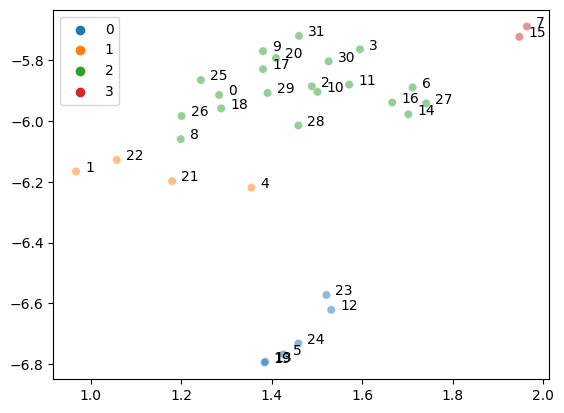

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get sample batch
sample = next(iter(data_loader))

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels,
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]),
            pd.Series(h_embedded[:,1]),
            pd.Series(annotations),
            plt.gca())

Finding the most similar and dissimilar data points

In [ ]:
import numpy as np

def sim_matrix(a,b,eps=1e-8):
  """
  Eps for numerical stability
  """
  a_n,b_n=a.norm(dim=1)[:,None],b.norm(dim=1)[:,None]
  a_norm=a/torch.max(a_n,eps*torch.ones_like(a_n))
  b_norm=b/torch.max(b_n,eps*torch.ones_like(b_n))
  sim_mt=torch.mm(a_norm,b_norm.transpose(0,1))
  return sim_mt

similarity=sim_matrix(h,h)
max_indices=torch.topk(similarity,k=2)[1][:,1]
max_vals=torch.topk(similarity,k=2)[0][:,1]

#Select index
idx=17
similar_idx=max_indices[idx]
print(f"Most similar data point in the empedding space for {idx} is {similar_idx} ")

Most similar data point in the empedding space for 17 is 20 


In [ ]:
plot_3d_shape(sample[idx].cpu())

Number of data points:  2846


In [ ]:
plot_3d_shape(sample[similar_idx].cpu())

Number of data points:  2809
